In [1]:
import torch
import torch.nn.functional as F
import model, utils
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

In [2]:
device = utils.get_device()

CUDA Available:  True


In [3]:
## To get the std and mean value

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
pixel_means = cifar10_train.data.mean(axis=(0,1,2)) / 255.0
pixel_stds = cifar10_train.data.std(axis=(0,1,2)) / 255.0

print('CIFAR-10 pixel means:', pixel_means)
print('CIFAR-10 pixel stds:', pixel_stds)

Files already downloaded and verified
CIFAR-10 pixel means: [0.49139968 0.48215841 0.44653091]
CIFAR-10 pixel stds: [0.24703223 0.24348513 0.26158784]


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.40, contrast=0.4, saturation=0.40, hue=0.4),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       #transforms.Resize((32, 32)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.ToTensor(),
                                       transforms.Normalize(pixel_means, pixel_stds),
                                       #transforms.RandomHorizontalFlip(p = 0.5),
                                       #transforms.RandomCrop(28, padding=4),
                                       #transforms.RandomErasing(p=0.5, scale=(0.2, 0.4), ratio=(0.3, 3.3))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(pixel_means, pixel_stds)
                                       ])

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

print(train.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


Files already downloaded and verified


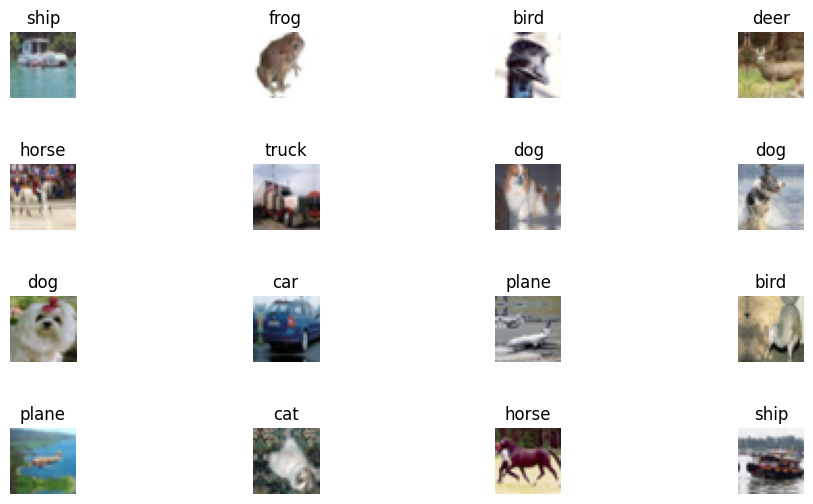

In [6]:
## Visulizing the data set

import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get a batch of images from the dataloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot the images using Matplotlib
fig, axs = plt.subplots(4, 4, figsize=(12, 6))
for i in range(16):
    # Calculate the subplot index
    row = i // 4
    col = i % 4
    # Unnormalize the image
    img = images[i] / 2 + 0.5
    # Convert the image to a NumPy array
    npimg = img.numpy()
    # Transpose the image from (C, H, W) to (H, W, C)
    npimg = np.transpose(npimg, (1, 2, 0))
    # Plot the image
    axs[row, col].imshow(npimg)
    axs[row, col].set_title(classes[labels[i]])
    axs[row, col].axis('off')

fig.subplots_adjust(hspace=1)
plt.show()

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cnnmodel = model.Net().to(device)
summary(cnnmodel, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             108
              ReLU-2            [-1, 4, 30, 30]               0
         LayerNorm-3            [-1, 4, 30, 30]           7,200
           Dropout-4            [-1, 4, 30, 30]               0
            Conv2d-5            [-1, 8, 28, 28]             288
              ReLU-6            [-1, 8, 28, 28]               0
         LayerNorm-7            [-1, 8, 28, 28]          12,544
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 4, 28, 28]              32
        MaxPool2d-10            [-1, 4, 14, 14]               0
           Conv2d-11           [-1, 10, 14, 14]             360
             ReLU-12           [-1, 10, 14, 14]               0

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(cnnmodel.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

EPOCHS = 20
criterion = F.nll_loss
misclassified = []
actual_labels = []
predicted_labels = []

In [10]:
for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  loss = model.train(cnnmodel, device, train_loader, criterion, optimizer, epoch)
  scheduler.step(loss)
  model.test(cnnmodel, device, test_loader)

Epoch 1


Loss=1.494110107421875 Batch_id=390 Accuracy=31.50: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]



Test set: Average loss: 1.5718, Accuracy: 4211/10000 (42.11%)

Epoch 2


Loss=1.365993857383728 Batch_id=390 Accuracy=42.77: 100%|██████████| 391/391 [00:38<00:00, 10.17it/s]



Test set: Average loss: 1.3878, Accuracy: 4874/10000 (48.74%)

Epoch 3


Loss=1.521357774734497 Batch_id=390 Accuracy=47.47: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 1.3519, Accuracy: 5171/10000 (51.71%)

Epoch 4


Loss=1.2676165103912354 Batch_id=390 Accuracy=51.32: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 1.1979, Accuracy: 5736/10000 (57.36%)

Epoch 5


Loss=1.3266832828521729 Batch_id=390 Accuracy=53.52: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 1.1705, Accuracy: 5838/10000 (58.38%)

Epoch 6


Loss=1.4147758483886719 Batch_id=390 Accuracy=54.95: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.



Test set: Average loss: 1.1446, Accuracy: 5886/10000 (58.86%)

Epoch 7


Loss=1.0915435552597046 Batch_id=390 Accuracy=58.35: 100%|██████████| 391/391 [00:38<00:00, 10.21it/s]



Test set: Average loss: 1.0374, Accuracy: 6310/10000 (63.10%)

Epoch 8


Loss=1.29158353805542 Batch_id=390 Accuracy=58.95: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]



Test set: Average loss: 1.0316, Accuracy: 6314/10000 (63.14%)

Epoch 9


Loss=0.9111999273300171 Batch_id=390 Accuracy=59.71: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.



Test set: Average loss: 1.0188, Accuracy: 6338/10000 (63.38%)

Epoch 10


Loss=1.2175242900848389 Batch_id=390 Accuracy=59.88: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 1.0127, Accuracy: 6387/10000 (63.87%)

Epoch 11


Loss=1.1902744770050049 Batch_id=390 Accuracy=60.14: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 1.0122, Accuracy: 6391/10000 (63.91%)

Epoch 12


Loss=1.1477535963058472 Batch_id=390 Accuracy=60.15: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s]

Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.



Test set: Average loss: 1.0085, Accuracy: 6398/10000 (63.98%)

Epoch 13


Loss=1.0582391023635864 Batch_id=390 Accuracy=60.45: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]



Test set: Average loss: 1.0093, Accuracy: 6399/10000 (63.99%)

Epoch 14


Loss=1.3047716617584229 Batch_id=390 Accuracy=60.37: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]



Test set: Average loss: 1.0092, Accuracy: 6396/10000 (63.96%)

Epoch 15


Loss=0.9066017270088196 Batch_id=390 Accuracy=60.28: 100%|██████████| 391/391 [00:35<00:00, 11.00it/s]

Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.



Test set: Average loss: 1.0091, Accuracy: 6398/10000 (63.98%)

Epoch 16


Loss=1.121751070022583 Batch_id=390 Accuracy=60.07: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]



Test set: Average loss: 1.0091, Accuracy: 6399/10000 (63.99%)

Epoch 17


Loss=0.9839008450508118 Batch_id=390 Accuracy=60.17: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]



Test set: Average loss: 1.0091, Accuracy: 6398/10000 (63.98%)

Epoch 18


Loss=1.0681583881378174 Batch_id=390 Accuracy=60.46: 100%|██████████| 391/391 [00:35<00:00, 10.96it/s]

Epoch 00018: reducing learning rate of group 0 to 1.0000e-07.



Test set: Average loss: 1.0090, Accuracy: 6397/10000 (63.97%)

Epoch 19


Loss=1.1464436054229736 Batch_id=390 Accuracy=60.12: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 1.0090, Accuracy: 6397/10000 (63.97%)

Epoch 20


Loss=1.21110200881958 Batch_id=390 Accuracy=60.18: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 1.0090, Accuracy: 6397/10000 (63.97%)



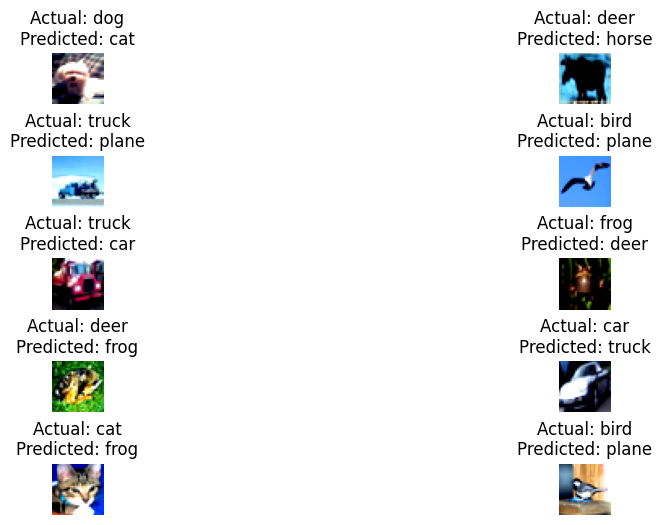

In [11]:
# To show the misclassified Images
model.plot_misclassifeid_images()

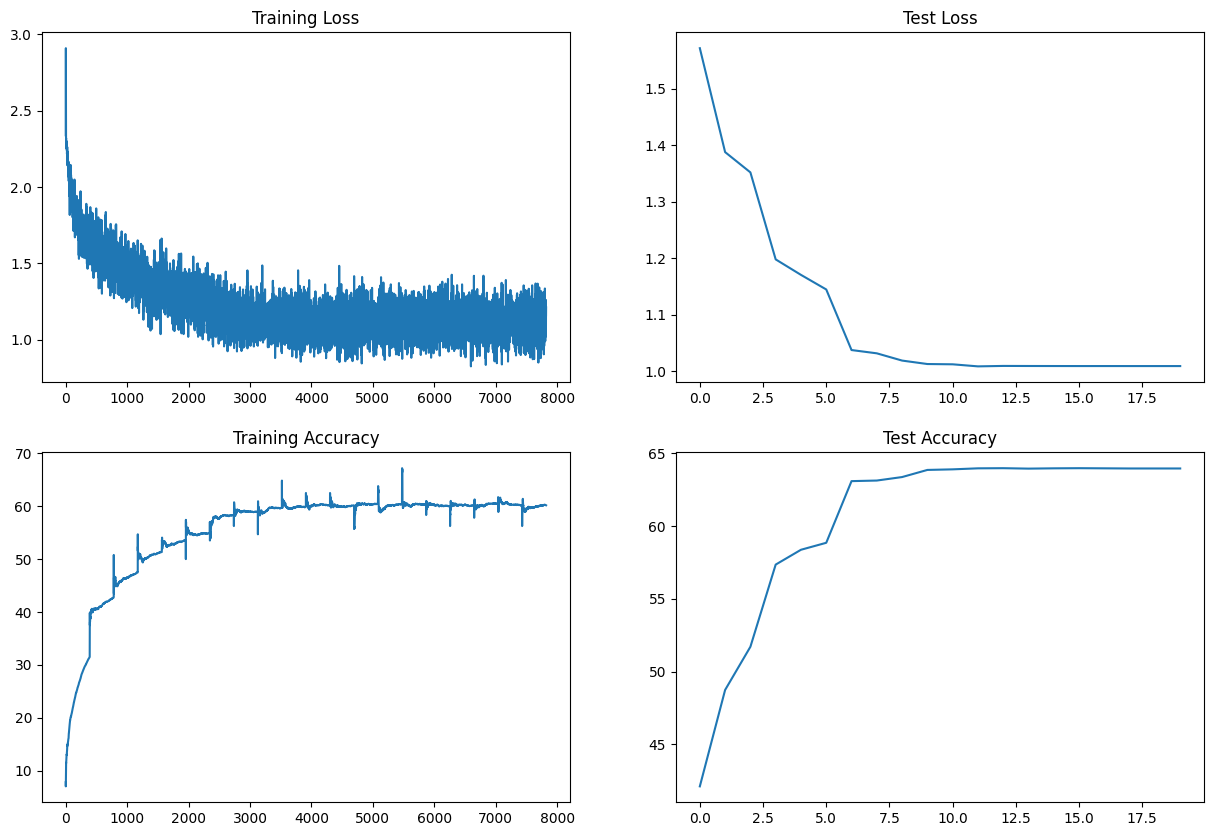

In [12]:
# Graph
model.plot_loss_accuracy_graph()